In [38]:
import pyodbc as pyodbc
from decouple import config

DB_SERVER = config('DB_SERVER', default='localhost')
# DB_SERVER = 'DESKTOP-55GPMAH\SQLE08' # con nombre de instancia
# DB_SERVER = '192.168.1.37,51370' # el puerto separado con coma
DB_PORT = config('DB_PORT', default='1433')
DB_NAME = config('DB_NAME', default='dbname')
DB_USER = config('DB_USER', default='username')
DB_PASSWORD = config('DB_PASSWORD', default='password')

connStr = ('DRIVER={ODBC Driver 17 for SQL Server};Server=%s,%s;port=%s;Database=%s;uid=%s;pwd=%s;') \
         % (DB_SERVER, DB_PORT, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr)
cursor = cnxn.cursor()
print(cnxn, cursor)

DRIVER={ODBC Driver 17 for SQL Server};Server=172.25.0.124,60388;port=60388;Database=ReplCS;uid=uniconuser01;pwd=87654321;
<pyodbc.Connection object at 0x7fd7768775e0> <pyodbc.Cursor object at 0x7fd776689558>


In [39]:
cursor.execute("SELECT top 10 order_date, truck_code, tkt_code, order_code from dbo.tgps;")
cursor.fetchall()

[(datetime.datetime(2018, 5, 16, 0, 0), '        89', '  448370', '           1'),
 (datetime.datetime(2018, 5, 16, 0, 0), '        59', '  448371', '           1'),
 (datetime.datetime(2018, 5, 16, 0, 0), '        59', '  448383', '          20'),
 (datetime.datetime(2018, 5, 16, 0, 0), '       169', '  448384', '           8'),
 (datetime.datetime(2018, 5, 16, 0, 0), '       170', '  448377', '           5'),
 (datetime.datetime(2018, 5, 16, 0, 0), '        52', '  448378', '          51'),
 (datetime.datetime(2018, 5, 16, 0, 0), '       430', '  448539', '         112'),
 (datetime.datetime(2018, 5, 16, 0, 0), '        52', '  448385', '           8'),
 (datetime.datetime(2018, 5, 16, 0, 0), '        89', '  448386', '           8'),
 (datetime.datetime(2018, 5, 16, 0, 0), '       121', '  448387', '           8')]

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [41]:
raw_data = {'truck_code': ['101', '303', '450', '136', '505'], 
        'diff_media': [70.85, 90.34, 52.40, 28.94, 47.52],
        'scale': [3, 4, 2, 1, 2],
        'ref_color': ['#4169E1', '#FF0000', '#FFFF00', '#00FF00', '#FFFF00']}
df = pd.DataFrame(raw_data, columns = ['truck_code', 'diff_media', 'scale', 'ref_color'])
df.head()

truck_code  diff_media  scale ref_color
0        101       70.85      3   #4169E1
1        303       90.34      4   #FF0000
2        450       52.40      2   #FFFF00
3        136       28.94      1   #00FF00
4        505       47.52      2   #FFFF00

In [42]:
scale_colors = {
        1:'#00FF00',
        2:'#FFFF00',
        3:'#4169E1',
        4:'#FF0000'
    }

def get_color_by_scale(scale):    
    return scale_colors.get(scale, 'black')

In [43]:
ref_colors = [get_color_by_scale(s) for s in df.scale]
print(ref_colors)

['#4169E1', '#FF0000', '#FFFF00', '#00FF00', '#FFFF00']


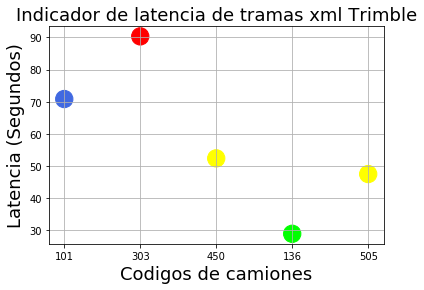

In [44]:
plt.scatter(df.truck_code, df.diff_media, s=300, c=ref_colors)
plt.title('Indicador de latencia de tramas xml Trimble', fontsize=18)
plt.xlabel('Codigos de camiones', fontsize=18)
plt.ylabel('Latencia (Segundos)', fontsize=18)
plt.grid(True)

In [45]:
import textwrap
sql = textwrap.dedent("""
select sm.* ,
	CASE 
		WHEN sm.diff_media BETWEEN 0 AND 29.999999 THEN 1
		WHEN sm.diff_media BETWEEN 30 AND 59.999999 THEN 2
		WHEN sm.diff_media BETWEEN 60 AND 89.999999 THEN 3
		ELSE 4
	END AS media_scale,
	CONVERT(INT, 
		CASE 
			WHEN ISNUMERIC(SUBSTRING(sm.truck_code,1,1))=1 THEN sm.truck_code 
			ELSE SUBSTRING(sm.truck_code,2,LEN(sm.truck_code)-1) 
		END) 
	AS truck_code_num
from replcs.dbo.trim_trama_sum sm WITH(NOLOCK)
JOIN [ReplCS].[dbo].[tgps] WITH(NOLOCK) ON  sm.order_date=CONVERT(DATE,tgps.order_date) 
									  --AND sm.truck_code=RTRIM(LTRIM(tgps.truck_code))
									  AND sm.tkt_code=RTRIM(LTRIM(tgps.tkt_code))
									  AND sm.order_code=RTRIM(LTRIM(tgps.order_code))
WHERE sm.order_date = '2018-05-16' -- CONVERT(DATE,GETDATE()) 
	and  sm.num_rec > 0 and fe_ini_receiver is not null
ORDER BY sm.order_date
	,sm.truck_code
	,sm.tkt_code
""")

In [109]:
dfQ = pd.read_sql(sql, cnxn)
print(dfQ.head())

   order_date truck_code tkt_code order_code  num_sen           fe_ini_sender  \
0  2018-05-16        170   448377          5       10 2018-05-16 09:52:43.017   
1  2018-05-16        212   448430         56       10 2018-05-16 09:52:43.060   
2  2018-05-16        212   448541        112       10 2018-05-16 09:52:43.033   
3  2018-05-16        212     9711          5       10 2018-05-16 09:52:43.193   
4  2018-05-16        218    51954         34       10 2018-05-16 09:52:43.090   

            fe_fin_sender  num_rec         fe_ini_receiver  \
0 2018-05-16 10:01:45.843       10 2018-05-16 09:53:23.990   
1 2018-05-16 10:01:45.917       10 2018-05-16 09:53:24.190   
2 2018-05-16 10:01:45.883       10 2018-05-16 09:53:23.987   
3 2018-05-16 10:01:46.060       10 2018-05-16 09:53:24.297   
4 2018-05-16 10:01:45.950       10 2018-05-16 09:53:24.220   

          fe_fin_receiver  diff_media  diff_mediana  diff_moda  diff_rango  \
0 2018-05-16 10:02:24.090       50.91           0.0        0.0

# Distintc values and group by

In [129]:
dfQ['media_scale'].value_counts()

2    88
1    64
3    11
Name: media_scale, dtype: int64

In [112]:
list(dfQ['media_scale'].value_counts(sort=True, ascending=True))

[11, 64, 88]

## Obtener el conteo de los rangos de latencia

In [192]:
gp = dfQ.groupby(['media_scale'])['truck_code'].count()
gpf = gp.to_frame()
total_camiones = gp.sum()
gpf

truck_code
media_scale            
1                    64
2                    88
3                    11

In [180]:
type(gp), list(gp)

(pandas.core.series.Series, [64, 88, 11])

In [184]:
dfTemp = pd.DataFrame({'truck_code': [0, 0, 0, 0]}, index=[1, 2, 3, 4])
dfTemp.index.name = "media_scale"
dfTemp

truck_code
media_scale            
1                     0
2                     0
3                     0
4                     0

In [187]:
dfFinal = gpf.join(dfTemp, how='right', lsuffix='_left', rsuffix='_right')
dfFinal

truck_code_left  truck_code_right
media_scale                                   
1                       64.0                 0
2                       88.0                 0
3                       11.0                 0
4                        NaN                 0

In [188]:
serieFinal = dfFinal['truck_code_left'].fillna(0)
serieFinal

media_scale
1    64.0
2    88.0
3    11.0
4     0.0
Name: truck_code_left, dtype: float64

In [194]:
# Con porcentajes
serieFinalPorcentajes = serieFinal / (total_camiones * 0.01)
serieFinalPorcentajes

media_scale
1    39.263804
2    53.987730
3     6.748466
4     0.000000
Name: truck_code_left, dtype: float64

In [191]:
list(serieFinal)

[64.0, 88.0, 11.0, 0.0]

In [198]:
serieFinalPorcentajes.round(2)

media_scale
1    39.26
2    53.99
3     6.75
4     0.00
Name: truck_code_left, dtype: float64

In [200]:
[str(i) + '%' for i in serieFinalPorcentajes.round(2)]

['39.26%', '53.99%', '6.75%', '0.0%']

## Continuacion

In [47]:
df2 = dfQ[['truck_code_num','diff_media', 'media_scale', 'fe_fin_sender', 'truck_code']]
ref_colors = [get_color_by_scale(s) for s in df2.media_scale]
print(df2.head(10))

   truck_code_num  diff_media  media_scale           fe_fin_sender truck_code
0             170       75.10            3 2018-05-16 10:01:45.843        170
1             212       33.85            2 2018-05-16 10:01:45.917        212
2             212        9.21            1 2018-05-16 10:01:45.883        212
3             212       55.42            2 2018-05-16 10:01:46.060        212
4             218       60.48            3 2018-05-16 10:01:45.950        218
5             219       49.74            2 2018-05-16 10:01:46.050        219
6             226       39.45            2 2018-05-16 10:01:45.970        226
7             229       60.48            3 2018-05-16 10:01:46.033        229
8             230       20.22            1 2018-05-16 10:01:46.023        230
9             233       87.01            3 2018-05-16 10:01:46.013        233


In [11]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

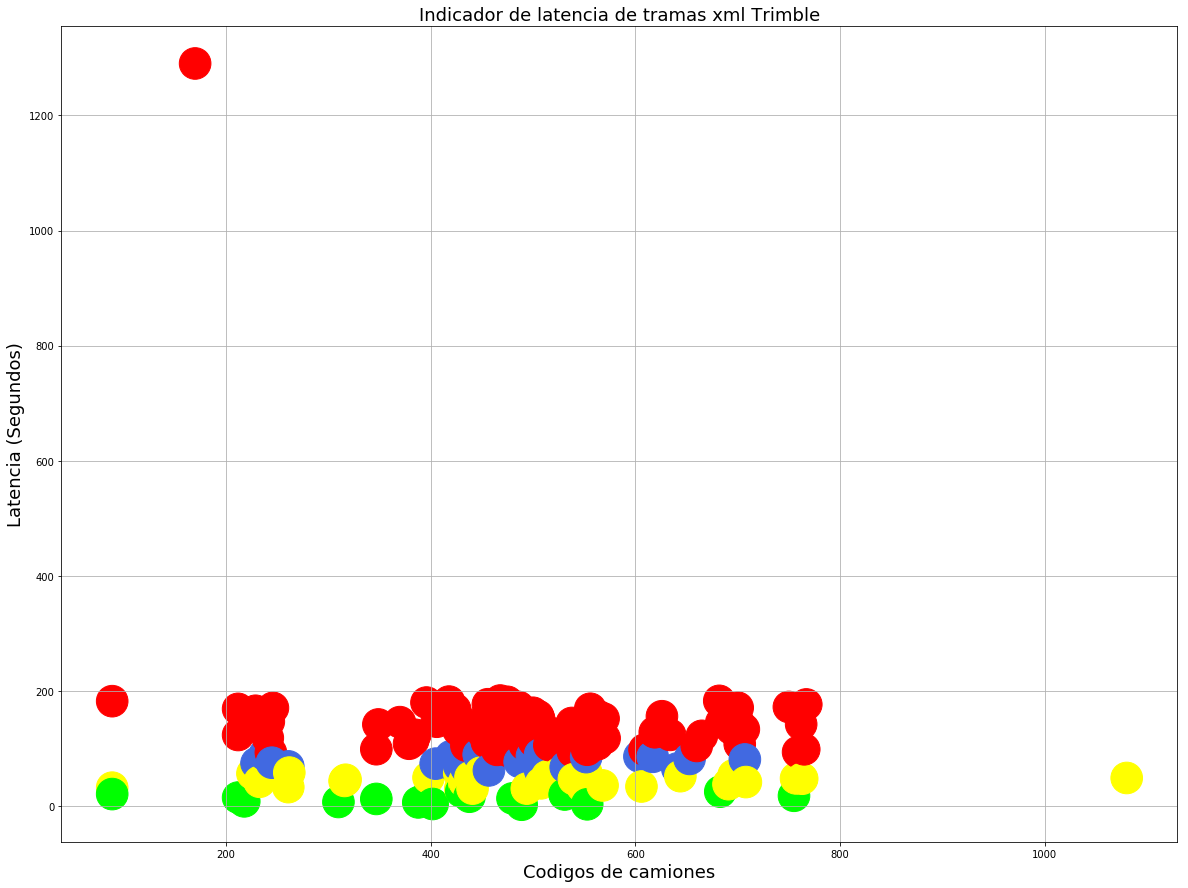

In [12]:
plt.scatter(df2.truck_code_num, df2.diff_media, s=1000, c=ref_colors)
plt.title('Indicador de latencia de tramas xml Trimble', fontsize=18)
plt.xlabel('Codigos de camiones', fontsize=18)
plt.ylabel('Latencia (Segundos)', fontsize=18)
plt.grid(True)

## Bokeh Scatter
### https://bokeh.pydata.org/en/latest/docs/gallery/color_scatter.html

In [13]:
import numpy as np

from bokeh.plotting import figure, show, output_file, save

N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

In [14]:
p = figure(tools=TOOLS)

p.scatter(x, y, radius=radii,
          fill_color=colors, fill_alpha=0.6,
          line_color=None)

output_file("color_scatter1.html", title="color_scatter.py example")
show(p) # open a browser

In [15]:
p = figure(tools=TOOLS, plot_width=1200, plot_height=800)
p.scatter(df2.truck_code_num, df2.diff_media, 
          fill_color=ref_colors, fill_alpha=0.6, 
          line_color=None, size=25)

output_file("indicadores_trimble.html", title="Indicadores de latencia de tramas de Trimble")
save(p)

'/app/indicadores_trimble.html'

In [16]:
import bokeh.models as bmo

scale_colors = {
        1:'#00FF00',
        2:'#FFFF00',
        3:'#4169E1',
        4:'#FF0000'
    }

ref_colors = [scale_colors[x] for x in df2['media_scale']]

In [36]:
# https://stackoverflow.com/questions/43983039/color-points-in-scatter-plot-of-bokeh
p = figure(tools=TOOLS, plot_width=1200, plot_height=800)
p.scatter(df2.truck_code_num, df2.diff_media, 
          color=ref_colors, 
          fill_alpha=0.6,
          line_color=None, size=25)
p.xaxis[0].axis_label = 'Weight (lbs)'
p.yaxis[0].axis_label = 'Height (in)'

source = bmo.ColumnDataSource(df2)
labels = bmo.LabelSet(x='truck_code_num', y='diff_media', text='truck_code', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')
p.add_layout(labels)

output_file("indicadores_trimble2.html", title="Indicadores de latencia de tramas de Trimble.")
save(p)

'/app/indicadores_trimble2.html'

In [1]:
from bokeh.server.server import Server

In [ ]:
Server